In [ ]:
pip install etna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.9/477.9 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.1 MB/s eta 0:00:00
   ━━━━

# Установка библиотек

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import time
from copy import deepcopy

import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import CatBoostPerSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import FourierTransform
from etna.transforms import HolidayTransform
from etna.transforms import LagTransform
from etna.transforms import MeanTransform
from etna.transforms import TrendTransform

# Выгрузка данных

In [ ]:

import pandas as pd

# Загружаем все три файла
dates_df = pd.read_csv('/content/shop_sales_dates.csv')
prices_df = pd.read_csv('/content/shop_sales_prices.csv')
sales_df = pd.read_csv('/content/shop_sales.csv')

In [ ]:
merged_df = sales_df.merge(dates_df, on='date_id', how='left')
final_merged_df = merged_df.merge(prices_df, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
df = final_merged_df

# Предобработка данных

In [ ]:
import pandas as pd
from etna.datasets import TSDataset

def aggregate(df: pd.DataFrame, granularity: int) -> TSDataset:
    """
    Агрегирует данные по заданной гранулярности (1 = день, 7 = неделя, 30 = месяц) и возвращает их в формате TSDataset.

    Параметры:
    - df: DataFrame с данными временных рядов.
    - granularity: число, определяющее гранулярность (1 - день, 7 - неделя, 30 - месяц).

    Возвращает:
    - Агрегированный TSDataset.
    """
    # Определяем частоту на основе переданного значения гранулярности
    if granularity == 1:
        freq = 'D'  # день
    elif granularity == 7:
        freq = 'W'  # неделя
    elif granularity == 30:
        freq = 'M'  # месяц
    else:
        raise ValueError("Гранулярность должна быть равна 1 (день), 7 (неделя) или 30 (месяц).")

    # Преобразуем DataFrame в формат TSDataset с дневной частотой
    tsdataset = TSDataset.to_dataset(df)

    # Применяем ресемплинг и агрегацию
    resampled_data = tsdataset.resample(freq).sum()

    # Возвращаем агрегированный TSDataset с заданной частотой
    aggregated_tsdataset = TSDataset(resampled_data, freq=freq)

    return aggregated_tsdataset


In [ ]:
merged_df = sales_df.merge(dates_df, on='date_id', how='left')
final_merged_df = merged_df.merge(prices_df, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

# Выбор конкретных товаров для эксперимента
selected_items = ['STORE_1_727', 'STORE_2_043']
final_merged_df = final_merged_df[final_merged_df['item_id'].isin(selected_items)]

In [ ]:
final_merged_df.head()

,item_id,store_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,sell_price
1819,STORE_2_043,STORE_2,1,6,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.88
1820,STORE_2_043,STORE_2,2,0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.88
1821,STORE_2_043,STORE_2,3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.88
1822,STORE_2_043,STORE_2,4,1,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,0,1,1,2.88
1823,STORE_2_043,STORE_2,5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,1,0,2.88


In [ ]:
target_name, date_name, segment_name, granularity   = 'cnt', 'date', 'item_id', 30

df = final_merged_df[['item_id', 'date', 'cnt', 'sell_price']]
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["cnt"]
df['segment'] = df['item_id']
df['price'] = df['sell_price']
df.drop(columns=["date", "cnt", 'item_id', 'sell_price'], inplace=True)
df = df[df['timestamp'] > '2013-05-01']
df.head()

,timestamp,target,segment,price
2643,2013-05-02,0,STORE_2_043,2.88
2644,2013-05-03,0,STORE_2_043,2.88
2645,2013-05-04,1,STORE_2_043,2.88
2646,2013-05-05,3,STORE_2_043,2.88
2647,2013-05-06,1,STORE_2_043,2.88


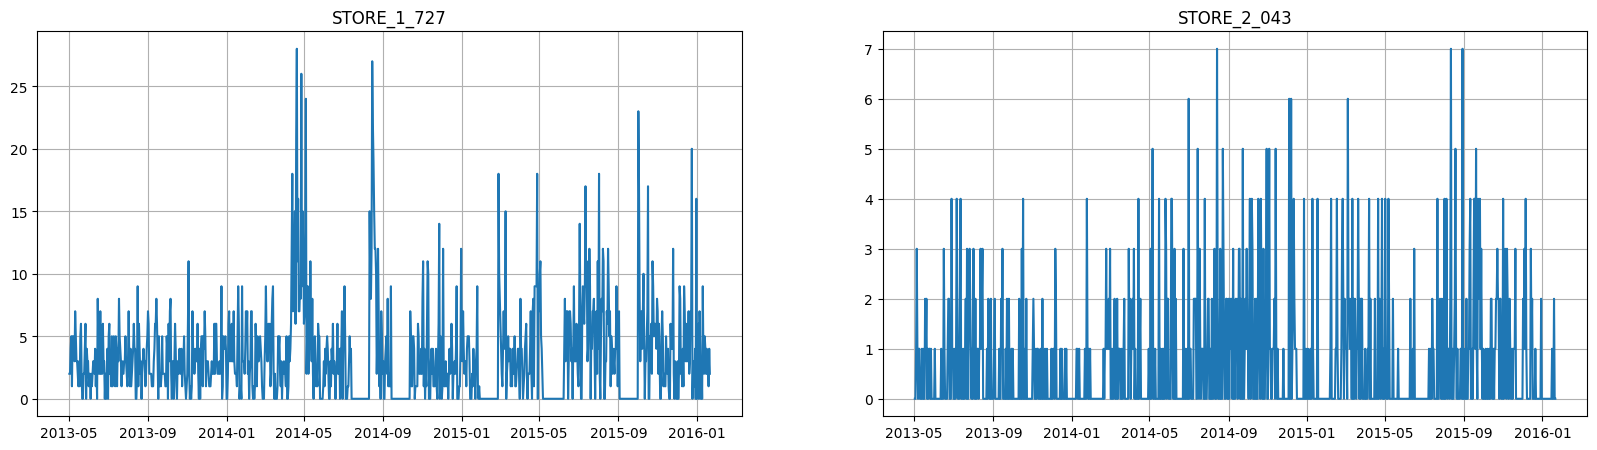

In [ ]:
ts = TSDataset(df, freq="D")
ts.plot(4)

In [ ]:
HORIZON = 60
transforms = [
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=range(HORIZON, 100), out_column="target_lag"),
    DateFlagsTransform(
        day_number_in_month=True, day_number_in_week=False, is_weekend=False, out_column="datetime_flag"
    ),
    MeanTransform(in_column=f"target_lag_{HORIZON}", window=12, seasonality=7, out_column="mean_transform"),
    FourierTransform(period=365, order=30, out_column="fourier_year"),
    FourierTransform(period=30.4, order=10, out_column="fourier_month"),
    HolidayTransform(iso_code="SWE", out_column="SWE_holidays"),
    HolidayTransform(iso_code="NOR", out_column="NOR_holidays"),
    HolidayTransform(iso_code="FIN", out_column="FIN_holidays"),
]

pipeline = Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)

In [ ]:
start_time = time.perf_counter()
metrics_baseline, forecast_baseline, _ = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=1)
time_baseline = time.perf_counter() - start_time

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   29.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   29.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


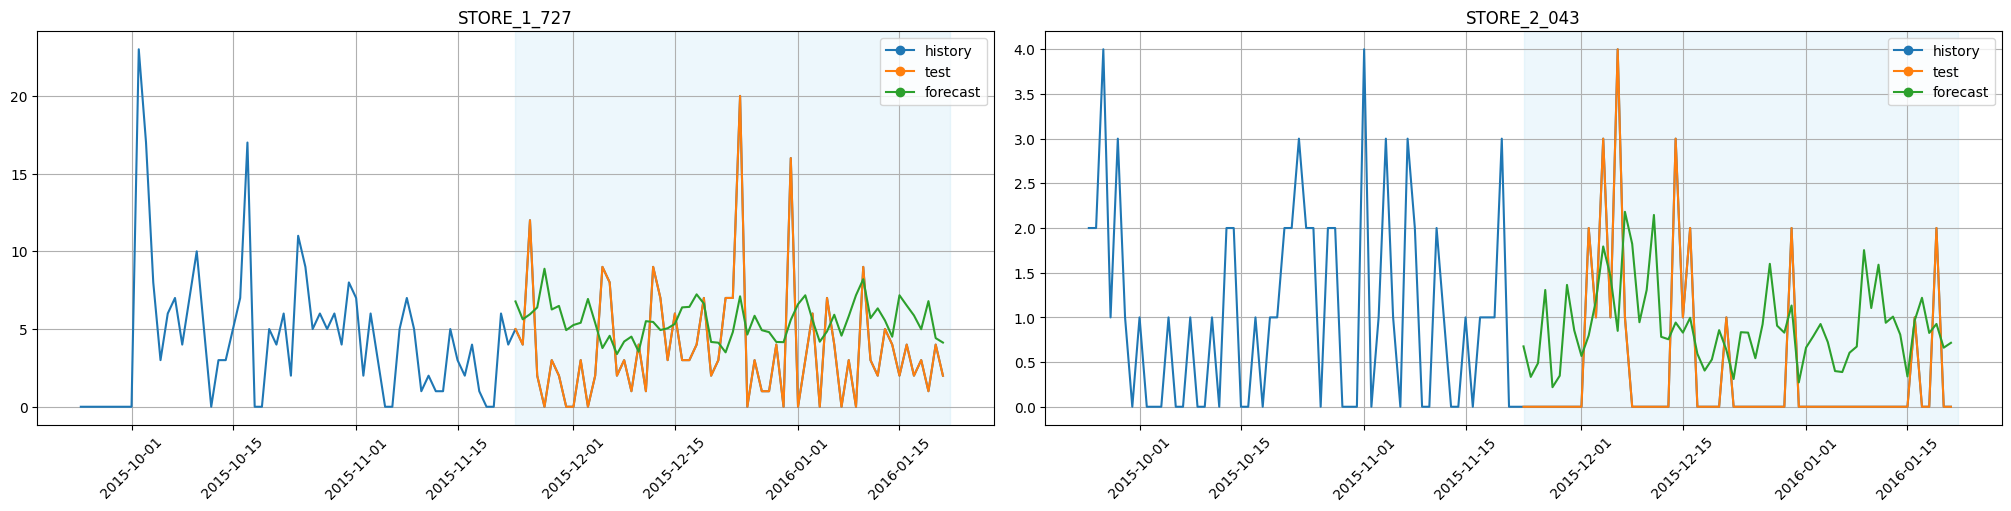

In [ ]:
plot_backtest(forecast_baseline, ts, history_len=60, segments=ts.segments[:4])

In [ ]:
smape_baseline = metrics_baseline["SMAPE"].mean()
print(f"SMAPE baseline: {smape_baseline:.3f}")
print(f"Time baseline: {time_baseline:.3f}")

SMAPE baseline: 127.239
Time baseline: 30.459


In [ ]:
temp_ts = deepcopy(ts)
temp_ts.fit_transform(transforms=transforms)

num_features = len(temp_ts.features) - 1
print(f"Num features: {num_features}")

Num features: 127


In [ ]:
from sklearn.tree import DecisionTreeRegressor

from etna.transforms import TreeFeatureSelectionTransform

model_feature_selection = DecisionTreeRegressor(random_state=42)
feature_selector_transform = TreeFeatureSelectionTransform(model=model_feature_selection, top_k=20)
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(), transforms=transforms + [feature_selector_transform], horizon=HORIZON
)

In [ ]:
start_time = time.perf_counter()
metrics_tree_feature_selector, forecast_tree_feature_selector, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=1
)
time_tree_feature_selector = time.perf_counter() - start_time

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


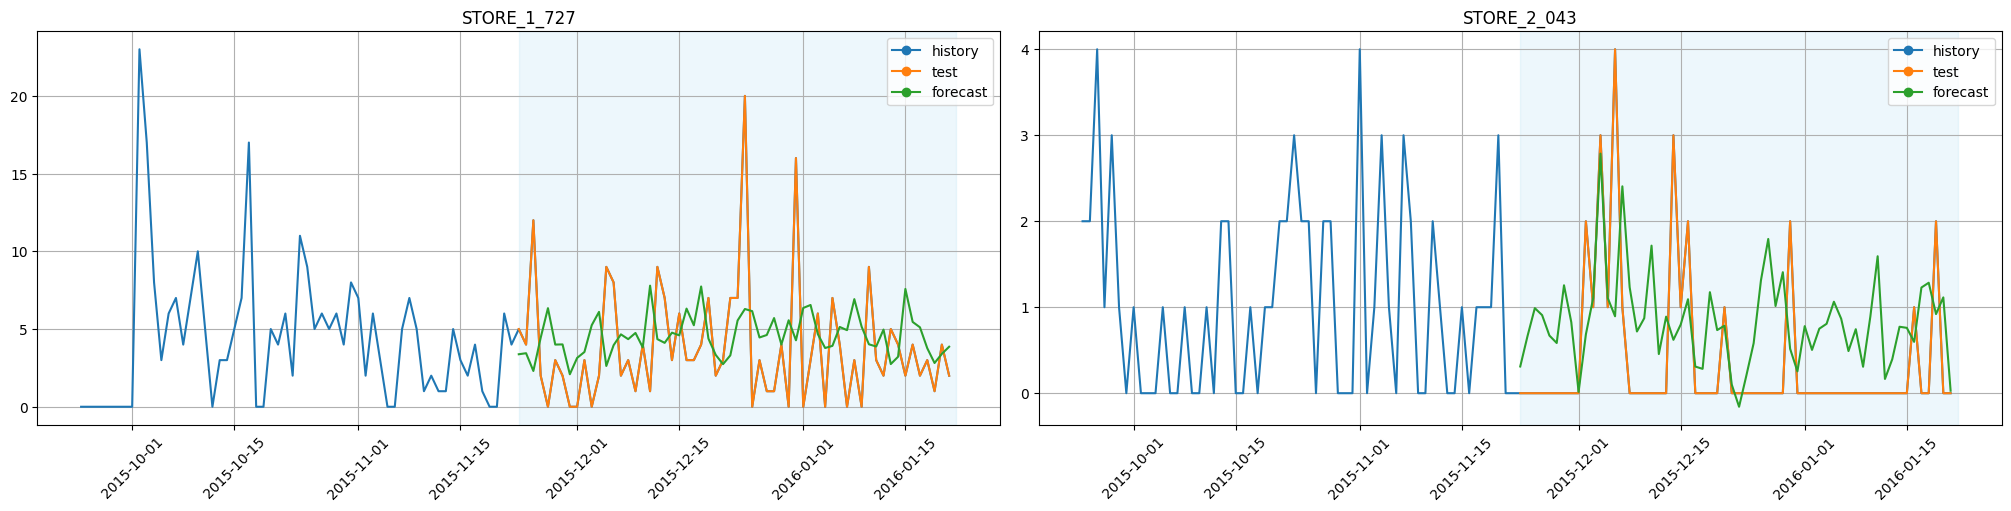

In [ ]:
plot_backtest(forecast_tree_feature_selector, ts, history_len=60, segments=ts.segments[:4])

In [ ]:
smape_tree_feature_selector = metrics_tree_feature_selector["SMAPE"].mean()
print(f"SMAPE with TreeFeatureSelectionTransform: {smape_tree_feature_selector:.3f}")
print(f"Time with TreeFeatureSelectionTransform: {time_tree_feature_selector:.3f}")

SMAPE with TreeFeatureSelectionTransform: 127.876
Time with TreeFeatureSelectionTransform: 6.610


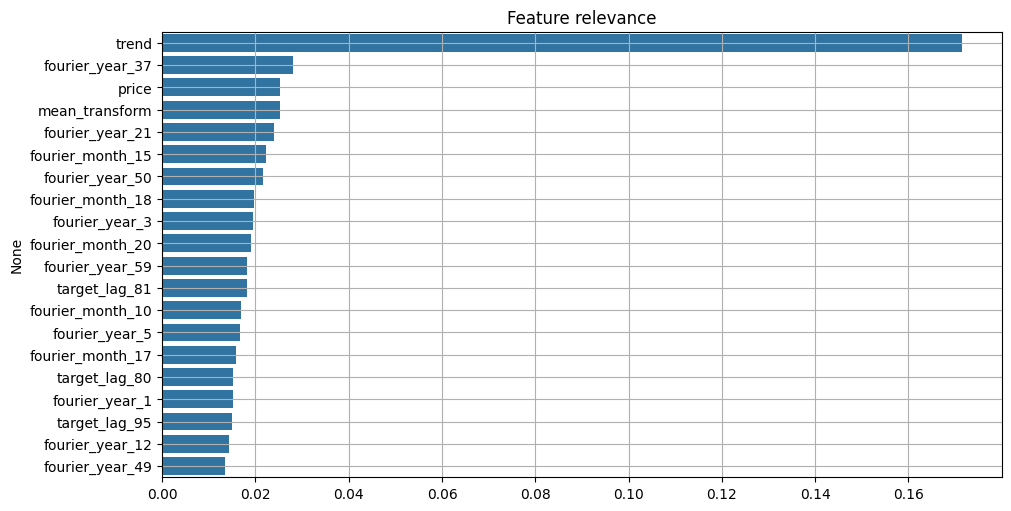

In [ ]:
from etna.analysis import ModelRelevanceTable
from etna.analysis import plot_feature_relevance

temp_ts = deepcopy(ts)
temp_ts.fit_transform(transforms=transforms)

plot_feature_relevance(
    temp_ts,
    relevance_table=ModelRelevanceTable(),
    top_k=20,
    relevance_params={"model": model_feature_selection},
)